## Comparing RF and SVC
No dimensionality reduction

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    cohen_kappa_score, matthews_corrcoef, roc_auc_score
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


### Regular split
No reduction

In [36]:
from sklearn.preprocessing import LabelEncoder
# Load your data
df = pd.read_csv('../datasets/ACDC_radiomics.csv')  
X = df.drop(columns=["class"])
y = df["class"]

# Encode labels if not numeric
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

### Defining pipelines

In [37]:
# Define pipelines
svc_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True))
])

rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # RF doesn't need scaling but kept for uniformity
    ("rf", RandomForestClassifier())
])

# Define parameter grids
svc_param_grid = {
    "svc__C": [0.1, 1, 10],
    "svc__kernel": ["linear", "rbf"],
    "svc__gamma": ["scale", "auto"]
}

rf_param_grid = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5]
}

### Grid Search

In [38]:
# Grid search
svc_grid = GridSearchCV(svc_pipeline, svc_param_grid, cv=5, scoring='accuracy')
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy')

svc_grid.fit(X_train, y_train)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None, 10, 20],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [100, 200]},
             scoring='accuracy')

### Best models
On accuracy

In [39]:
# Best models
svc_best = svc_grid.best_estimator_
rf_best = rf_grid.best_estimator_

# Predict
svc_pred = svc_best.predict(X_test)
rf_pred = rf_best.predict(X_test)

# Probabilities for AUC
svc_proba = svc_best.predict_proba(X_test)
rf_proba = rf_best.predict_proba(X_test)

# Binarize y for multiclass AUC
y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))

# Evaluation metrics
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n{name} Evaluation Metrics:")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("Cohen's Kappa:", cohen_kappa_score(y_true, y_pred))
    print("Matthews Corrcoef:", matthews_corrcoef(y_true, y_pred))
    print("AUC (macro):", roc_auc_score(y_test_bin, y_proba, multi_class="ovr", average="macro"))

# Evaluate both models
evaluate_model("SVC", y_test, svc_pred, svc_proba)
evaluate_model("Random Forest", y_test, rf_pred, rf_proba)


SVC Evaluation Metrics:
Accuracy : 0.8333333333333334
Recall (macro): 0.8333333333333333
Precision (macro): 0.8647619047619047
F1 Score (macro): 0.831888111888112
Cohen's Kappa: 0.7916666666666666
Matthews Corrcoef: 0.8006123366751
AUC (macro): 0.9472222222222222

Random Forest Evaluation Metrics:
Accuracy : 0.8333333333333334
Recall (macro): 0.8333333333333334
Precision (macro): 0.8357142857142856
F1 Score (macro): 0.824895104895105
Cohen's Kappa: 0.7916666666666666
Matthews Corrcoef: 0.7961018087453642
AUC (macro): 0.923611111111111


### Cross validation scores

C:\Users\dani1\AppData\Local\Temp\ipykernel_31596\1656360547.py:47: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.25'` for the same effect.

  sns.swarmplot(data=all_results, x="Metric", y="Score", hue="Model", dodge=True, color=".25", alpha=0.7)


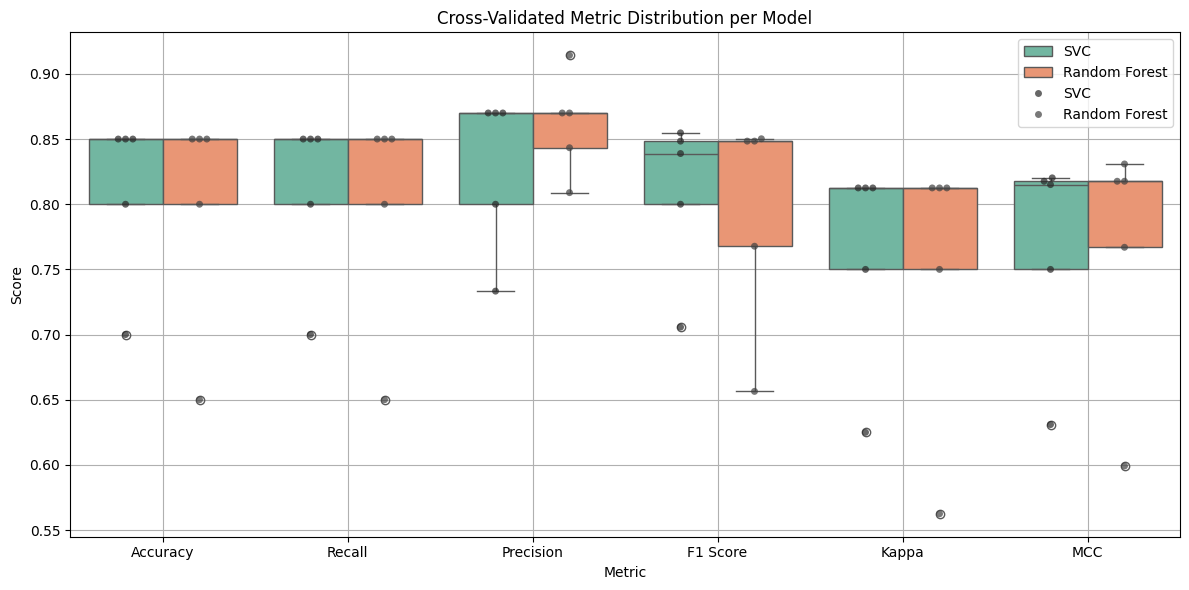

In [40]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    cohen_kappa_score, matthews_corrcoef
)
import seaborn as sns
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to get predictions per fold for a model
def get_cv_predictions(model, X, y, cv):
    return cross_val_predict(model, X, y, cv=cv)

# Function to compute all metrics
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred, average='macro'),
        "Precision": precision_score(y_true, y_pred, average='macro'),
        "F1 Score": f1_score(y_true, y_pred, average='macro'),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "MCC": matthews_corrcoef(y_true, y_pred)
    }

# Collect metrics for each fold manually
def collect_cv_metrics(model, X, y, cv, label):
    results = []
    for train_idx, test_idx in cv.split(X, y):
        model.fit(X.iloc[train_idx], y[train_idx])
        y_pred = model.predict(X.iloc[test_idx])
        metrics = compute_metrics(y[test_idx], y_pred)
        for metric_name, value in metrics.items():
            results.append({"Model": label, "Metric": metric_name, "Score": value})
    return results

# Compute for both models
svc_results = collect_cv_metrics(svc_best, X, y_encoded, cv, "SVC")
rf_results = collect_cv_metrics(rf_best, X, y_encoded, cv, "Random Forest")

# Combine and plot
all_results = pd.DataFrame(svc_results + rf_results)

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_results, x="Metric", y="Score", hue="Model", palette="Set2")
sns.swarmplot(data=all_results, x="Metric", y="Score", hue="Model", dodge=True, color=".25", alpha=0.7)
plt.title("Cross-Validated Metric Distribution per Model")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


### Model with best accuracy behaviour

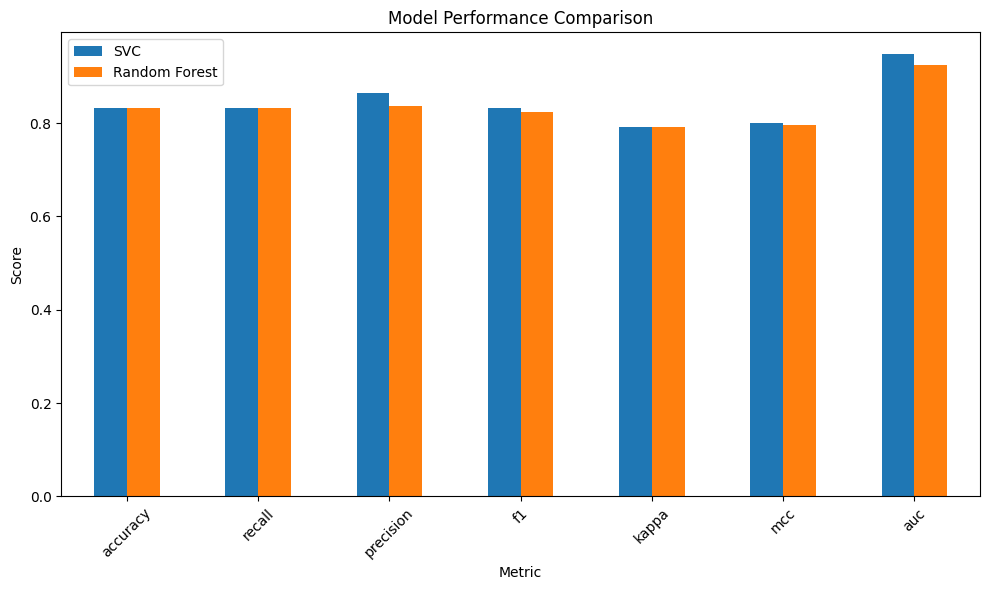

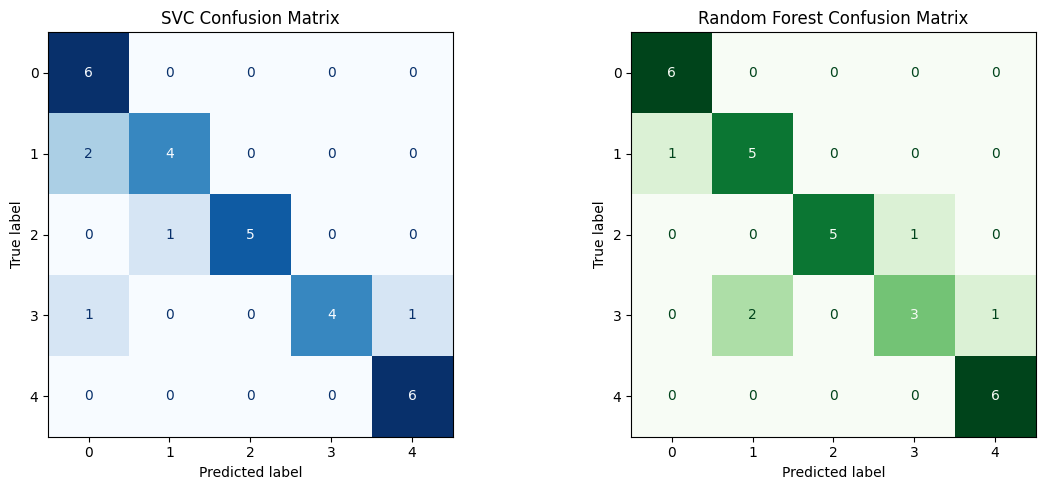

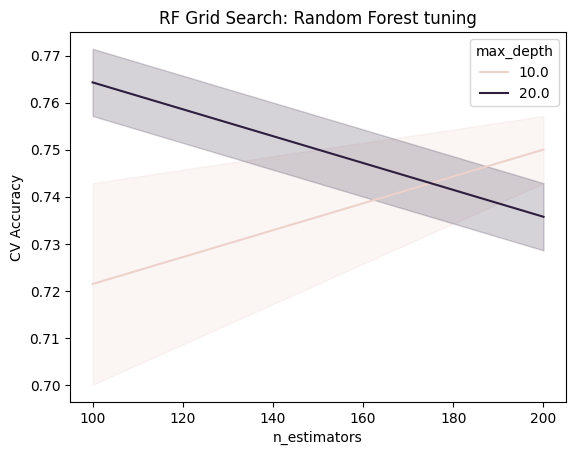

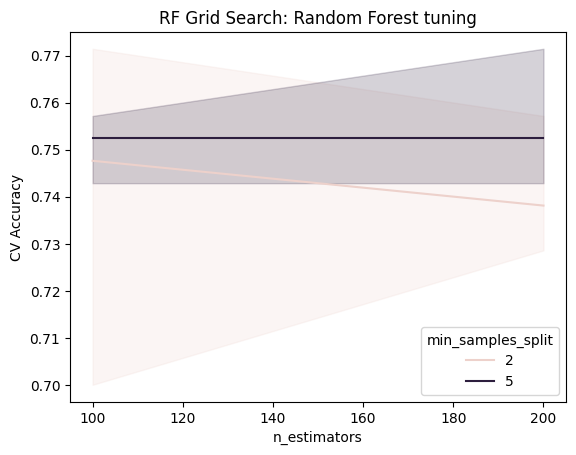

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# === 1. Compare Metrics (Bar Plot) ===
metrics = ['accuracy', 'recall', 'precision', 'f1', 'kappa', 'mcc', 'auc']
svc_scores = [
    accuracy_score(y_test, svc_pred),
    recall_score(y_test, svc_pred, average='macro'),
    precision_score(y_test, svc_pred, average='macro'),
    f1_score(y_test, svc_pred, average='macro'),
    cohen_kappa_score(y_test, svc_pred),
    matthews_corrcoef(y_test, svc_pred),
    roc_auc_score(y_test_bin, svc_proba, multi_class="ovr", average="macro")
]
rf_scores = [
    accuracy_score(y_test, rf_pred),
    recall_score(y_test, rf_pred, average='macro'),
    precision_score(y_test, rf_pred, average='macro'),
    f1_score(y_test, rf_pred, average='macro'),
    cohen_kappa_score(y_test, rf_pred),
    matthews_corrcoef(y_test, rf_pred),
    roc_auc_score(y_test_bin, rf_proba, multi_class="ovr", average="macro")
]

df_scores = pd.DataFrame({
    'Metric': metrics,
    'SVC': svc_scores,
    'Random Forest': rf_scores
})

df_scores.set_index("Metric").plot(kind='bar', figsize=(10, 6), title="Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 2. Confusion Matrices ===
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, svc_pred, ax=ax[0], cmap='Blues', colorbar=False)
ax[0].set_title("SVC Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred, ax=ax[1], cmap='Greens', colorbar=False)
ax[1].set_title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

# === 3. GridSearchCV Tuning Results Plot ===
def plot_cv_results(grid_search, title):
    results = pd.DataFrame(grid_search.cv_results_)
    if 'svc__C' in results.columns:
        pivot = results.pivot(index='param_svc__C', columns='param_svc__gamma', values='mean_test_score')
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
        plt.title(f"{title}: SVC C vs Gamma")
        plt.ylabel("C")
        plt.xlabel("Gamma")
        plt.show()
    elif 'param_rf__n_estimators' in results.columns:
        for param in ['param_rf__max_depth', 'param_rf__min_samples_split']:
            sns.lineplot(data=results, x='param_rf__n_estimators', y='mean_test_score', hue=param)
            plt.title(f"{title}: Random Forest tuning")
            plt.ylabel("CV Accuracy")
            plt.xlabel("n_estimators")
            plt.legend(title=param.split('__')[-1])
            plt.show()

plot_cv_results(svc_grid, "SVC Grid Search")
plot_cv_results(rf_grid, "RF Grid Search")
